# Late Fusion: Video Modeling

## Setup

In [1]:
import os
from glob import glob
from pathlib import Path
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
import pickle
import copy

from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score

### Paths

In [2]:
input_path = '../../../2.data_preparation/out/video/'
output_path = '../out/video/'
# Global configuration path
glob_conf_path = '../../../config/global_config.py'

### Load global variables

In [3]:
exec(open(glob_conf_path).read())

### Load data

In [4]:
train_intensity_df = pd.read_csv(input_path + 'video_data_intensity_late_fusion_train.csv')
test_intensity_df = pd.read_csv(input_path + 'video_data_intensity_late_fusion_test.csv')

#train_presence_df = pd.read_csv(input_path + 'video_data_presence_train.csv')
#test_presence_df = pd.read_csv(input_path + 'video_data_presence_test.csv')

### Other functions

In [5]:
from sklearn.metrics import confusion_matrix

def plot_save_conf_matrix(X_test, y_test, clf, title, file_name, report=False):
    scores = clf.predict_proba(X_test_db)           # Predict probabilities
    AUC_test = roc_auc_score(y_true=y_test_db,
                             y_score=scores,
                             average='macro',
                             multi_class='ovo')  # Get AUC score
    print('AUC (test):', AUC_test)
    
    y_pred = clf.predict(X_test_db)
    conf_mat = confusion_matrix(y_test_db, y_pred, normalize='true')
    df_cm = pd.DataFrame(conf_mat, list(emotion_id_to_emotion_num.keys()), list(emotion_id_to_emotion_num.keys()))
    
    fig=plt.figure(figsize=(15,15))
    ax = sns.heatmap(df_cm, annot=True, fmt='.2f', vmin=0, vmax=1, cmap=conf_cmap)
    plt.yticks(va='center')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    if report == True:
        plt.savefig(os.path.join(output_path,'confusion_matrix','report_'+file_name), bbox_inches = 'tight') 
    plt.title(title)
    plt.savefig(os.path.join(output_path,'confusion_matrix',file_name), bbox_inches = 'tight')
    plt.show()

## Elastic Net SGD Classifier

### Intensity Dataset

In [5]:
from sklearn.linear_model import SGDClassifier


# Get train features and labels from the dataset
feat = [col for col in train_intensity_df if col.startswith('AU')]
X_train_db = train_intensity_df[feat]
y_train_db =  train_intensity_df.target


# Create new variables to split the train dataset into k folds (considering groups)
X = X_train_db
y = y_train_db
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

# Define parameters to evaluate
alpha_values    = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.03, 0.05, 0.07, 0.1, 1]
loss_values     = ['log', 'modified_huber']
l1_ratio_values = np.arange(0.05, 1.05, 0.05).tolist()
parameters      = [(alpha,loss,l1_ratio)  
                   for alpha in alpha_values
                   for loss in loss_values
                   for l1_ratio in l1_ratio_values
                  ]

# Initialize some variables to store results
results = []
AUC_avg_best_model = 0
params_best_model = None
for i in tqdm(range(len(parameters))):
    AUC_avg = 0  # Initialize average AUC
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]
        
        # Compute class weight
        class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
        class_weight = {n:class_weight[n] for n in range(0,18)}
        
        # Create new classifier and fit it (train dataset)
        clf = SGDClassifier(penalty      = 'elasticnet',
                            alpha        = parameters[i][0],
                            loss         = parameters[i][1],
                            l1_ratio     = parameters[i][2],
                            random_state = seed,
                            n_jobs       = -1,
                            class_weight = class_weight
                           )
        clf.fit(X_train,y_train)
        
        # Compute results (validation dataset)
        scores = clf.predict_proba(X_val)           # Predict probabilities
        AUC_tmp = roc_auc_score(y_true=y_val,
                                y_score=scores,
                                average='macro',
                                multi_class='ovo')  # Get AUC score
        AUC_avg += AUC_tmp                          # Add new AUC
    
    AUC_avg /= n_folds                              # Get average AUC for alpha = a
    
    # Add new results to the results list
    results.append(['elasticnet',                   # Penalty
                    parameters[i][0],               # Alpha
                    parameters[i][1],               # Loss
                    parameters[i][2],               # L1_ratio
                    AUC_avg
                   ])
    
    # Check if current average AUC is better than the stored
    if AUC_avg > AUC_avg_best_model:
        AUC_avg_best_model = AUC_avg                # Update best average AUC
        params_best_model = parameters[i]           # Update best model parameters

        
# Store the results in a DataFrame and then save them as csv
results_df = pd.DataFrame(data=results, columns=['Penalty','Alpha','Loss','L1_ratio','AUC_avg'])
results_df.to_csv(os.path.join(output_path,'results','res_elastic_net_'+str(n_folds)+'_fold_cv_intensity_video.csv'), index=None, header=True)


# Train model with the parameters of the best model (using full training set)        
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_db), y=y_train_db)
class_weight = {n:class_weight[n] for n in range(0,18)}
best_model = SGDClassifier(penalty      = 'elasticnet',
                           alpha        = params_best_model[0],
                           loss         = params_best_model[1],
                           l1_ratio     = params_best_model[2],
                           random_state = seed,
                           n_jobs       = -1,
                           class_weight = class_weight
                          )
best_model.fit(X_train_db, y_train_db)    # Fit model

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_elastic_net_intensity_video.sav')
pickle.dump(best_model, open(file_path, 'wb'))

print(best_model)

100%|██████████| 400/400 [08:33<00:00,  1.28s/it]

SGDClassifier(alpha=0.0001, average=False,
              class_weight={0: 2.2801932367149758, 1: 0.7712418300653595,
                            2: 2.2801932367149758, 3: 0.7827529021558872,
                            4: 2.2801932367149758, 5: 0.7827529021558872,
                            6: 0.7827529021558872, 7: 2.2801932367149758,
                            8: 0.7827529021558872, 9: 0.7827529021558872,
                            10: 0.7712418300653595, 11: 0.7827529021558872,
                            12: 2.2801932367149758, 13: 0.7827529021558872,
                            14: 0.7827529021558872, 15: 0.7827529021558872,
                            16: 2.2801932367149758, 17: 0.7827529021558872},
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.7000000000000001, learning_rate='optimal', loss='log',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1,
              penalty='elasticnet', power_t=0.5, random_state=2

In [6]:
results_df.sort_values(by='AUC_avg', ascending=False).head()

,Penalty,Alpha,Loss,L1_ratio,AUC_avg
93,elasticnet,0.0001,log,0.70,0.806973
96,elasticnet,0.0001,log,0.85,0.806859
94,elasticnet,0.0001,log,0.75,0.806843
91,elasticnet,0.0001,log,0.60,0.806832
95,elasticnet,0.0001,log,0.80,0.806809


AUC (test): 0.7845091668187842


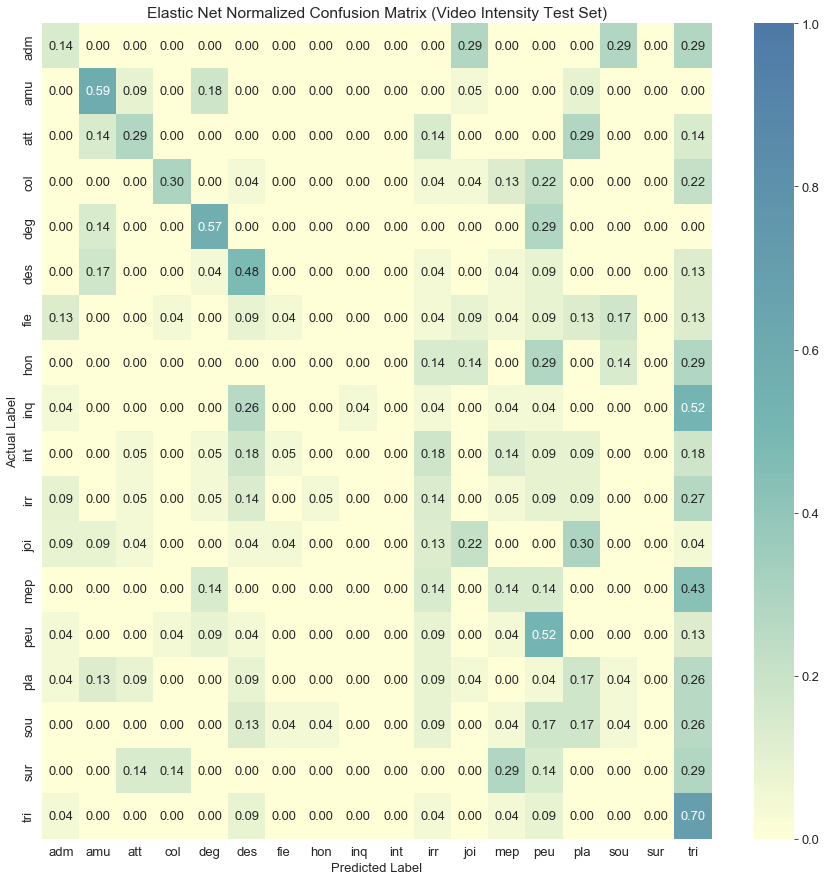

In [6]:
from sklearn.metrics import confusion_matrix

# Get test features and labels from the dataset 
feat = [col for col in train_intensity_df if col.startswith('AU')]
X_test_db = test_intensity_df[feat]
y_test_db =  test_intensity_df.target

# load the model from disk
file_path = os.path.join(output_path,'models','mod_elastic_net_intensity_video.sav')
clf = pickle.load(open(file_path, 'rb'))

plot_save_conf_matrix(X_test    = X_test_db,
                      y_test    = y_test_db,
                      clf       = clf,
                      title     = 'Elastic Net Normalized Confusion Matrix (Video Intensity Test Set)',
                      file_name = 'conf_mat_elastic_net_intensity_video.svg'
                     )

## kNN Classifier

### Intensity dataset

In [8]:
from sklearn.neighbors import KNeighborsClassifier


# Get train features and labels from the dataset 
feat = [col for col in train_intensity_df if col.startswith('AU')]
X_train_db = train_intensity_df[feat]
y_train_db =  train_intensity_df.target

# Create new variables to split the train dataset into k folds (considering groups)
X = X_train_db
y = y_train_db
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

# Define parameters to evaluate
n_neigh_values   = np.arange(50, 405, 5).tolist()
leaf_size_values = np.arange(30, 310, 5).tolist()
weights_values   = ['uniform', 'distance']
parameters = [(n_neigh,leaf_size,weights)  
              for n_neigh in n_neigh_values
              for leaf_size in leaf_size_values
              for weights in weights_values
             ]

# Initialize some variables to store results
results = []
AUC_avg_best_model = 0
params_best_model = None
for i in tqdm(range(len(parameters))):
    AUC_avg = 0 # Initialize average AUC
    for train_idx, val_idx in skf.split(X, y): 
        X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]
        
        # Create a new classifier and fit it (train dataset)
        clf = KNeighborsClassifier(n_neighbors  = parameters[i][0],
                                   leaf_size    = parameters[i][1],
                                   weights      = parameters[i][2],
                                   n_jobs       = -1
                                  )
        clf.fit(X_train,y_train)
        
        # Compute results (validation dataset)
        scores = clf.predict_proba(X_val)             # Predict probability
        AUC_tmp = roc_auc_score(y_true=y_val,
                                y_score=scores,
                                average='macro',
                                multi_class='ovo')    # Get AUC score
        AUC_avg += AUC_tmp                            # Add new AUC score
    
    AUC_avg /= n_folds                                # Get average AUC for alpha = a
    
    # Add new results to the results list
    results.append([parameters[i][0],                 # n_neighbors
                    parameters[i][1],                 # leaf_size
                    parameters[i][2],                 # weights
                    AUC_avg
                   ])
    
    # Check if current average AUC is better than the stored
    if AUC_avg > AUC_avg_best_model:
        AUC_avg_best_model = AUC_avg                  # Update best average AUC
        params_best_model = parameters[i]             # Update best model parameters

        
# Store the results in a DataFrame and then save them as csv
results_df = pd.DataFrame(data=results, columns=['k_neighbors','leaf_size','weights','AUC_avg'])
results_df.to_csv(os.path.join(output_path,'results','res_knn_'+str(n_folds)+'_fold_cv_intensity_video.csv') , index=None, header=True)



# Train model with the parameters of the best model (using full training set)        
best_model = KNeighborsClassifier(n_neighbors  = params_best_model[0],
                                  leaf_size    = params_best_model[1],
                                  weights      = params_best_model[2],
                                  n_jobs       = -1
                                 )
best_model.fit(X_train_db, y_train_db)    # Fit model

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_knn_intensity_video.sav')
pickle.dump(best_model, open(file_path, 'wb'))

print(best_model)

100%|██████████| 7952/7952 [3:10:44<00:00,  1.44s/it]  

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=75, p=2,
                     weights='distance')


In [9]:
results_df.sort_values(by='AUC_avg', ascending=False).head()

,k_neighbors,leaf_size,weights,AUC_avg
617,75,170,distance,0.804593
587,75,95,distance,0.804593
609,75,150,distance,0.804593
607,75,145,distance,0.804593
605,75,140,distance,0.804593


AUC (test): 0.7790069951126676


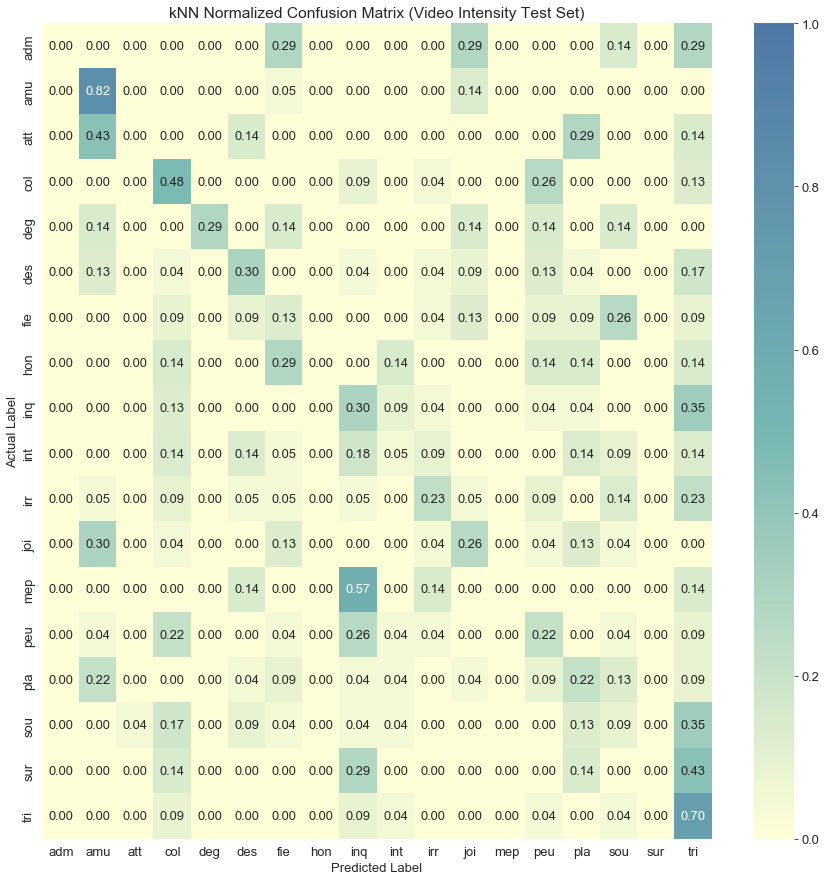

In [7]:
from sklearn.metrics import confusion_matrix

# Get test features and labels from the dataset
feat = [col for col in train_intensity_df if col.startswith('AU')]
X_test_db = test_intensity_df[feat]
y_test_db =  test_intensity_df.target

# load the model from disk
file_path = os.path.join(output_path,'models','mod_knn_intensity_video.sav')
clf = pickle.load(open(file_path, 'rb'))

plot_save_conf_matrix(X_test    = X_test_db,
                      y_test    = y_test_db,
                      clf       = clf,
                      title     = 'kNN Normalized Confusion Matrix (Video Intensity Test Set)',
                      file_name = 'conf_mat_knn_intensity_video.svg'
                     )

## Decision Tree

In [11]:
from sklearn.tree import DecisionTreeClassifier


# Get train features and labels from the dataset 
feat = [col for col in train_intensity_df if col.startswith('AU')]
X_train_db = train_intensity_df[feat]
y_train_db =  train_intensity_df.target

# Create new variables to split the train dataset into k folds (considering groups)
X = X_train_db
y = y_train_db
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)


# Define parameters to evaluate
criterion_values         = ['gini', 'entropy']
splitter_values          = ['best', 'random']
max_depth_values         = np.arange(5, 55, 5).tolist()
min_samples_split_values = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_leaf_values  = np.linspace(0.1, 0.5, 5, endpoint=True)
max_features_values      = list(range(1,len(feat)))
parameters = [(criterion,splitter,max_depth,min_samples_split,min_samples_leaf,max_features)  
              for criterion in criterion_values
              for splitter in splitter_values
              for max_depth in max_depth_values
              for min_samples_split in min_samples_split_values
              for min_samples_leaf in min_samples_leaf_values
              for max_features in max_features_values
             ]

# Initialize some variables to store results
results = []
AUC_avg_best_model = 0
params_best_model = None
for i in tqdm(range(len(parameters))):
    AUC_avg = 0 # Initialize average AUC
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]
        
        # Compute class weight
        class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
        class_weight = {n:class_weight[n] for n in range(0,18)}
        
        # Create a new classifier and fit it (train dataset)
        clf = DecisionTreeClassifier(criterion         = parameters[i][0],
                                     splitter          = parameters[i][1],
                                     max_depth         = parameters[i][2],
                                     min_samples_split = parameters[i][3],
                                     min_samples_leaf  = parameters[i][4],
                                     max_features      = parameters[i][5],
                                     random_state      = seed,
                                     class_weight      = class_weight
                                  )
        clf.fit(X_train,y_train)
        

        scores = clf.predict_proba(X_val)             # Predict probabilities
        AUC_tmp = roc_auc_score(y_true=y_val,
                                y_score=scores,
                                average='macro',
                                multi_class='ovo')    # Get AUC score
        AUC_avg += AUC_tmp                            # Add new AUC
    
    AUC_avg /= n_folds                                # Get average AUC for alpha = a
    
    # Add new results to the results list
    results.append([parameters[i][0],                 # criterion
                    parameters[i][1],                 # splitter
                    parameters[i][2],                 # max_depth
                    parameters[i][3],                 # min_samples_split
                    parameters[i][4],                 # min_samples_leaf
                    parameters[i][5],                 # max_features
                    AUC_avg
                   ])
    
    # Check if current average AUC is better than the stored
    if AUC_avg > AUC_avg_best_model:
        AUC_avg_best_model = AUC_avg                # Update best average AUC
        params_best_model = parameters[i]           # Update best model parameters

        
# Store the results in a DataFrame and then save them as csv
results_df = pd.DataFrame(data=results, columns=['criterion','splitter','max_depth','min_samples_split','min_samples_leaf','max_features','AUC_avg'])
results_df.to_csv(os.path.join(output_path,'results','res_tree_'+str(n_folds)+'_fold_cv_intensity_video.csv') , index=None, header=True)


# Train model with the parameters of the best model (using full training set)
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_db), y=y_train_db)
class_weight = {n:class_weight[n] for n in range(0,18)}
best_model = DecisionTreeClassifier(criterion         = params_best_model[0],
                                    splitter          = params_best_model[1],
                                    max_depth         = params_best_model[2],
                                    min_samples_split = params_best_model[3],
                                    min_samples_leaf  = params_best_model[4],
                                    max_features      = params_best_model[5],
                                    random_state      = seed,
                                    class_weight      = class_weight
                                  )
best_model.fit(X_train_db, y_train_db)    # Fit model

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_tree_intensity_video.sav')
pickle.dump(best_model, open(file_path, 'wb'))

print(best_model)

100%|██████████| 32000/32000 [6:55:41<00:00,  1.28it/s]   


DecisionTreeClassifier(ccp_alpha=0.0,
                       class_weight={0: 2.2801932367149758,
                                     1: 0.7712418300653595,
                                     2: 2.2801932367149758,
                                     3: 0.7827529021558872,
                                     4: 2.2801932367149758,
                                     5: 0.7827529021558872,
                                     6: 0.7827529021558872,
                                     7: 2.2801932367149758,
                                     8: 0.7827529021558872,
                                     9: 0.7827529021558872,
                                     10: 0.7712418300653595,
                                     11: 0.7827529021558872,
                                     12: 2.2801932367149758,
                                     13: 0.7827529021558872,
                                     14: 0.7827529021558872,
                                     15: 0.78275290215588

In [12]:
results_df.sort_values(by='AUC_avg', ascending=False).head()

,criterion,splitter,max_depth,min_samples_split,min_samples_leaf,max_features,AUC_avg
20888,entropy,best,35,0.2,0.1,9,0.722892
16088,entropy,best,5,0.2,0.1,9,0.722892
20808,entropy,best,35,0.1,0.1,9,0.722892
16008,entropy,best,5,0.1,0.1,9,0.722892
20088,entropy,best,30,0.2,0.1,9,0.722892


AUC (test): 0.6940626842059918


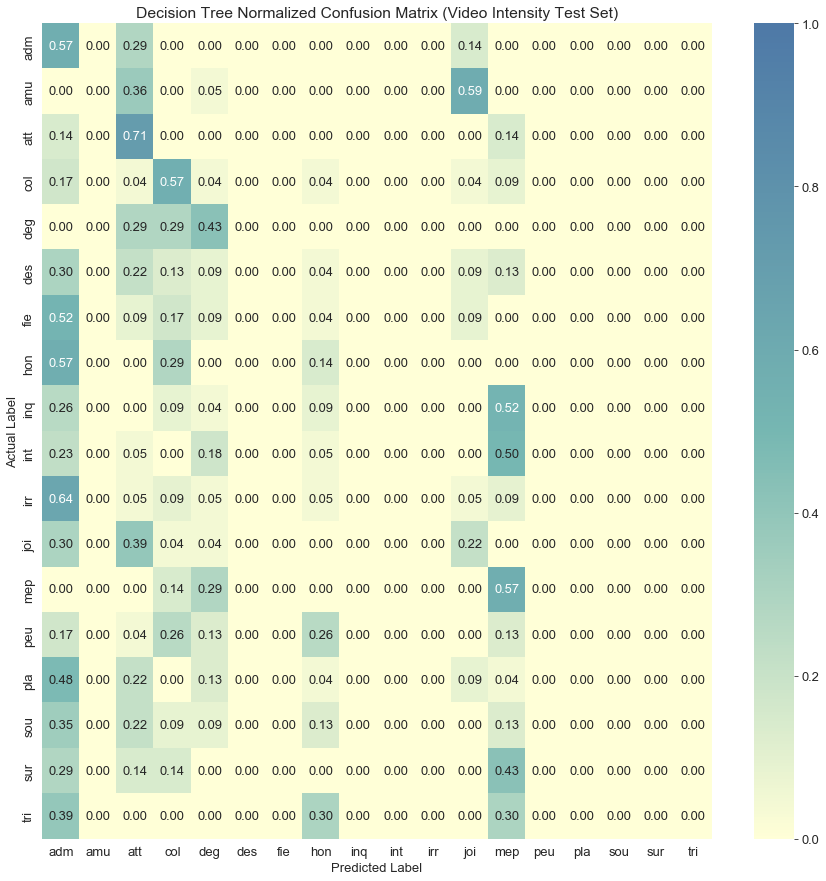

In [8]:
from sklearn.metrics import confusion_matrix

# Get test features and labels from the dataset
feat = [col for col in train_intensity_df if col.startswith('AU')]
X_test_db = test_intensity_df[feat]
y_test_db =  test_intensity_df.target

# load the model from disk
file_path = os.path.join(output_path,'models','mod_tree_intensity_video.sav')
clf = pickle.load(open(file_path, 'rb'))

plot_save_conf_matrix(X_test    = X_test_db,
                      y_test    = y_test_db,
                      clf       = clf,
                      title     = 'Decision Tree Normalized Confusion Matrix (Video Intensity Test Set)',
                      file_name = 'conf_mat_tree_intensity_video.svg'
                     )

## Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample


# Get train features and labels from the dataset 
feat = [col for col in train_intensity_df if col.startswith('AU')]
X_train_db = train_intensity_df[feat]
y_train_db =  train_intensity_df.target

# Create new variables to split the train dataset into k folds (considering groups)
X = X_train_db
y = y_train_db
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

# Define parameters to evaluate
n_estimators_values      = [int(x) for x in np.linspace(10, 500, num = 100)]#np.arange(100, 810, 10).tolist()
criterion_values         = ['gini']
max_features_values      = ['auto', 'sqrt']
max_depth_values         = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth_values.append(None)
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values  = [1, 2, 4]
bootstrap_values         = [True, False]
parameters = [(n_estimators, criterion, max_features, max_depth, min_samples_split, min_samples_leaf, bootstrap)  
              for n_estimators in n_estimators_values
              for criterion in criterion_values
              for max_features in max_features_values
              for max_depth in max_depth_values
              for min_samples_split in min_samples_split_values
              for min_samples_leaf in min_samples_leaf_values
              for bootstrap in bootstrap_values
             ]
#print(len(parameters))

# Randomized Search CV (we need randomize search beacuse there are a lot of combinations)
parameters = resample(parameters, n_samples=5000, replace=False, random_state=seed)


# Initialize some variables to store results
results = []
AUC_avg_best_model = 0
params_best_model = None
for i in tqdm(range(len(parameters))):
    # Create classifier
    clf = RandomForestClassifier(n_estimators      = parameters[i][0],
                                 criterion         = parameters[i][1],
                                 max_features      = parameters[i][2],
                                 max_depth         = parameters[i][3],
                                 min_samples_split = parameters[i][4],
                                 min_samples_leaf  = parameters[i][5],
                                 bootstrap         = parameters[i][6],
                                 random_state      = seed,
                                 n_jobs            = -1
                                )
    AUC_avg = 0 # Initialize average AUC
    for train_idx, val_idx in skf.split(X, y): 
        X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]
        
        # Compute class weight
        class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
        class_weight = {n:class_weight[n] for n in range(0,18)}
        
        # Modify classifier class weight and fit the model (train dataset)
        clf.class_weight = class_weight
        clf.fit(X_train,y_train)
        
        # Compute results (validation dataset)
        scores = clf.predict_proba(X_val)             # Predict probability
        AUC_tmp = roc_auc_score(y_true=y_val,
                                y_score=scores,
                                average='macro',
                                multi_class='ovo')    # Get AUC score
        AUC_avg += AUC_tmp                            # Add new AUC score
    
    AUC_avg /= n_folds                                # Get average AUC for alpha = a
    
    # Add new results to the results list
    results.append([parameters[i][0],                 # n_estimators
                    parameters[i][1],                 # criterion
                    parameters[i][2],                 # max_features
                    parameters[i][3],                 # max_depth
                    parameters[i][4],                 # min_samples_split
                    parameters[i][5],                 # min_samples_leaf
                    parameters[i][6],                 # bootstrap
                    AUC_avg
                   ])
    
    # Check if current average AUC is better than the stored
    if AUC_avg > AUC_avg_best_model:
        AUC_avg_best_model = AUC_avg                  # Update best average AUC
        params_best_model = parameters[i]             # Update best model parameters

        
# Store the results in a DataFrame and then save them as csv
results_df = pd.DataFrame(data=results, columns=['n_estimators','criterion','max_features','max_depth','min_samples_split','min_samples_leaf','bootstrap','AUC_avg'])
results_df.to_csv(os.path.join(output_path,'results','res_rf_'+str(n_folds)+'_fold_cv_intensity_video.csv') , index=None, header=True)

class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_db), y=y_train_db)
class_weight = {n:class_weight[n] for n in range(0,18)}

# Train model with the parameters of the best model (using full training set)        
best_model = RandomForestClassifier(n_estimators      = params_best_model[0],
                                    criterion         = params_best_model[1],
                                    max_features      = params_best_model[2],
                                    max_depth         = params_best_model[3],
                                    min_samples_split = params_best_model[4],
                                    min_samples_leaf  = params_best_model[5],
                                    bootstrap         = params_best_model[6],
                                    random_state      = seed,
                                    class_weight      = class_weight,
                                    n_jobs            = -1
                                   )
best_model.fit(X_train_db, y_train_db)    # Fit model

# Save the best model to disk
file_path = os.path.join(output_path,'models','mod_rf_intensity_video.sav')
pickle.dump(best_model, open(file_path, 'wb'))

print(best_model)

100%|██████████| 5000/5000 [6:52:53<00:00,  4.95s/it]  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 2.2801932367149758,
                                     1: 0.7712418300653595,
                                     2: 2.2801932367149758,
                                     3: 0.7827529021558872,
                                     4: 2.2801932367149758,
                                     5: 0.7827529021558872,
                                     6: 0.7827529021558872,
                                     7: 2.2801932367149758,
                                     8: 0.7827529021558872,
                                     9: 0.7827529021558872,
                                     10: 0.7712418300653595,
                                     11: 0.7827529021558872,
                                     12: 2.2801932367149758,
                                     13: 0.782...
                                     15: 0.7827529021558872,
                                     16: 2.280193236

In [15]:
results_df.sort_values(by='AUC_avg', ascending=False).head()

,n_estimators,criterion,max_features,max_depth,min_samples_split,min_samples_leaf,bootstrap,AUC_avg
2712,490,gini,sqrt,10.0,2,2,True,0.832329
224,495,gini,sqrt,10.0,2,2,True,0.832311
2957,425,gini,sqrt,10.0,5,2,True,0.832003
600,470,gini,sqrt,10.0,2,2,True,0.831984
2408,410,gini,sqrt,10.0,5,2,True,0.831566


AUC (test): 0.8115987147461484


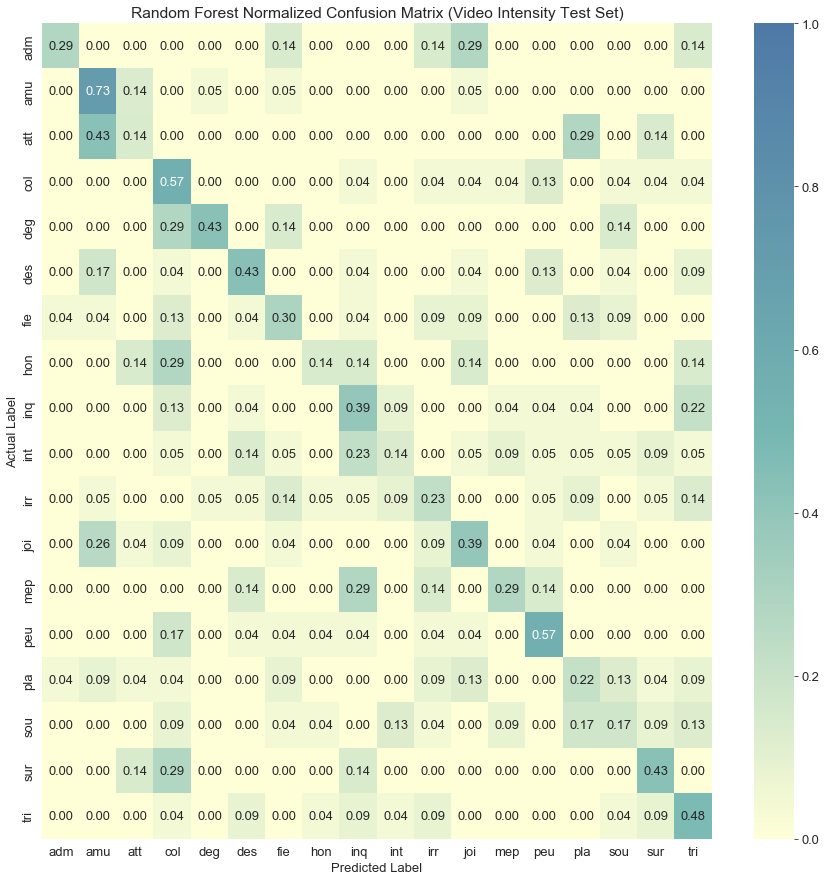

In [11]:
from sklearn.metrics import confusion_matrix

# Get test features and labels from the dataset
feat = [col for col in train_intensity_df if col.startswith('AU')]
X_test_db = test_intensity_df[feat]
y_test_db =  test_intensity_df.target

# load the model from disk
file_path = os.path.join(output_path,'models','mod_rf_intensity_video.sav')
clf = pickle.load(open(file_path, 'rb'))

plot_save_conf_matrix(X_test    = X_test_db,
                      y_test    = y_test_db,
                      clf       = clf,
                      title     = 'Random Forest Normalized Confusion Matrix (Video Intensity Test Set)',
                      file_name = 'conf_mat_rf_intensity_video.svg',
                      report    = True 
                     )

## BEST MODEL VALIDATION CONFUSION MATRIX

AUC_avg (validation): 0.8323287792434527


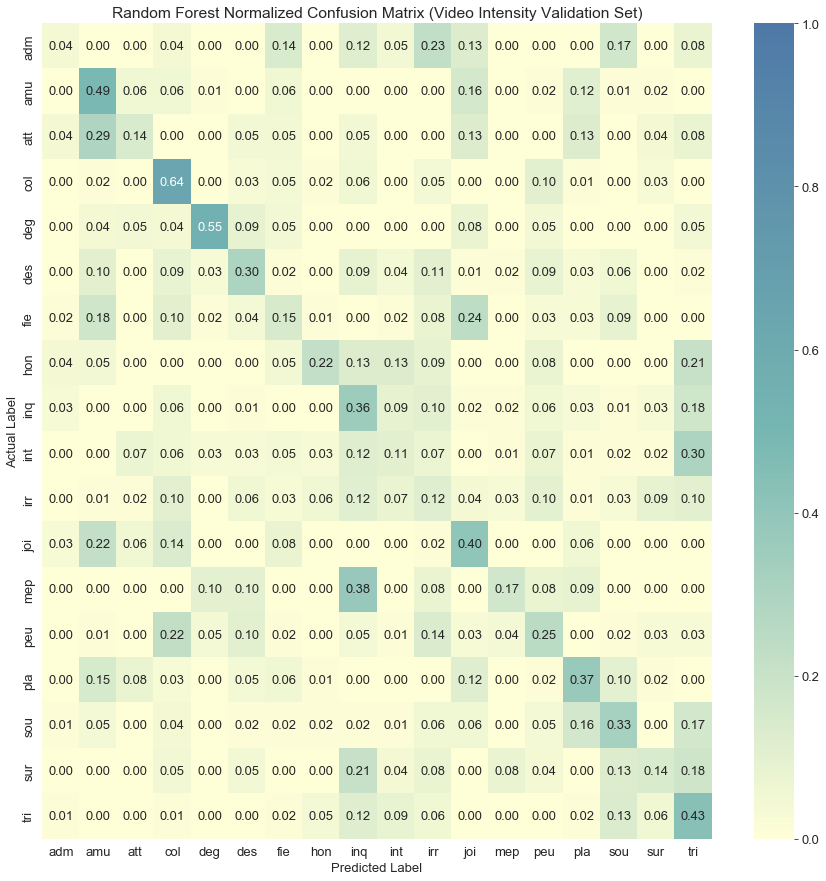

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix

                
clf = RandomForestClassifier(n_estimators      = 490,            # Create video model with best parameters
                             criterion         = 'gini',
                             max_features      = 'sqrt',
                             max_depth         = 10,
                             min_samples_split = 2,
                             min_samples_leaf  = 2,
                             bootstrap         = True,
                             random_state      = seed,
                             n_jobs            = -1
                            ) 



# Get train features and labels from the dataset 
feat = [col for col in train_intensity_df if col.startswith('AU')]
X_train_db = train_intensity_df[feat]
y_train_db =  train_intensity_df.target

# Create new variables to split the train dataset into k folds (considering groups)
X = X_train_db
y = y_train_db
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)



# Initialize some variables to store results
results = []
AUC_avg = 0 # Initialize average AUC
conf_mat_avg = np.zeros([18,18])
for train_idx, val_idx in skf.split(X, y): 
    X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]
    
    # Compute class weight
    class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weight = {n:class_weight[n] for n in range(0,18)}
    
    # Modify classifier class weight and fit the model (train dataset)
    clf.class_weight = class_weight
    clf.fit(X_train,y_train)
    
    # Compute results (validation dataset)
    scores = clf.predict_proba(X_val)                 # Predict probability
    AUC_tmp = roc_auc_score(y_true=y_val,
                            y_score=scores,
                            average='macro',
                            multi_class='ovo')        # Get AUC score
    AUC_avg += AUC_tmp                                # Add new AUC score
    
    y_pred = clf.predict(X_val)                       # Predict class
    conf_mat_tmp = confusion_matrix(y_val,            # Compute confusion matrix for this batch
                                    y_pred,
                                    normalize='true'
                                   )
    conf_mat_avg += conf_mat_tmp

AUC_avg /= n_folds                                    # Get average AUC for alpha = a
print('AUC_avg (validation):',AUC_avg)
conf_mat_avg /= n_folds


df_cm = pd.DataFrame(conf_mat_avg, list(emotion_id_to_emotion_num.keys()), list(emotion_id_to_emotion_num.keys()))

plt.figure(figsize=(15,15))
sns.heatmap(df_cm, annot=True, fmt='.2f', vmin=0, vmax=1, cmap=conf_cmap)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.yticks(va='center')
plt.savefig(os.path.join(output_path,'confusion_matrix','report_conf_mat_rf_intensity_video_validation.svg'), bbox_inches = 'tight')
plt.title('Random Forest Normalized Confusion Matrix (Video Intensity Validation Set)')
plt.savefig(os.path.join(output_path,'confusion_matrix','conf_mat_rf_intensity_video_validation.svg'), bbox_inches = 'tight')
#plt.show()
